In [2]:
import anndata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd

ad = anndata.read_h5ad('/home/yuanh/sc_basset/Buenrostro_2018/sc_peakset/raw/ad.h5ad')

def shared_neighbor_label(ad, label_obs_idx):
    sc.pp.neighbors(ad, n_neighbors=101, use_rep='projection') # 100 nearest neighbor of each cell
    m_ATAC_neighbors = [i.indices for i in ad.obsp['distances']] # neighbor idx for each cell
    neighbor_label = ad.obs.iloc[np.concatenate(m_ATAC_neighbors, axis=0), label_obs_idx] # label for all neighbors
    cell_label = ad.obs.iloc[np.repeat(np.arange(len(m_ATAC_neighbors)), [len(j) for j in m_ATAC_neighbors]), label_obs_idx] # label for all cells
    n_shared = (neighbor_label.values==cell_label.values).sum() / len(m_ATAC_neighbors)
    return n_shared


# compute adjusted rand index
# copied from https://github.com/pinellolab/scATAC-benchmarking/blob/master/Synthetic_Data/BoneMarrow_clean/run_clustering_bonemarrow_clean.ipynb
def getNClusters(adata,n_cluster,range_min=0,range_max=3,max_steps=20):
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.louvain(adata,resolution=this_resolution)
        this_clusters = adata.obs['louvain'].nunique()
        if this_clusters > n_cluster:
            this_max = this_resolution
        elif this_clusters < n_cluster:
            this_min = this_resolution
        else:
            return(this_resolution, adata)
        this_step += 1
    return (None, None)

In [12]:
PCs = [10, 20, 30, 40, 50]
scores = []
embed = pd.read_csv('embed.csv', index_col=0).values
for i in PCs:
    ad.obsm['projection'] = embed[:,:i]
    n_shared = shared_neighbor_label(ad, 1)
    scores += [n_shared]
    
output = pd.DataFrame({'PCs':PCs,  'score':scores})
output.to_csv('shared_neighbor_label.csv')

In [13]:
output

,PCs,score
0,10,68.942970
1,20,67.450344
2,30,65.090954
3,40,61.839233
4,50,58.277778


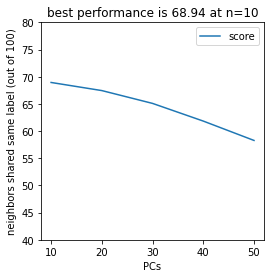

In [14]:
best_n = PCs[output['score'].argmax()]
best_val = output['score'].max()
f, ax = plt.subplots(figsize=(4,4))
output.plot.line(x='PCs', y='score', ax=ax)
ax.set_ylabel('neighbors shared same label (out of 100)')
ax.set_title('best performance is %.2f at n=%d'%(best_val, best_n))
ax.set_ylim(40, 80)
f.savefig('eval.pdf')

In [ ]:
ad.obsm["projection"] = embed[:,:10]
sc.pp.neighbors(ad, use_rep="projection")
sc.tl.umap(ad)

sc.pp.neighbors(ad, use_rep='projection')
sc.tl.tsne(ad, use_rep='projection')

f, ax = plt.subplots(figsize=(4, 4))
sc.pl.tsne(ad, color='label', ax=ax)
f.savefig('tsne_label.pdf')